# CL Test

## Installation
Install all the necessary library.

In [ ]:
! pip install avalanche-lib==0.3.1
! pip install micromind

In [1]:
import torch
import torch.nn as nn
from torch.optim import SGD, Adam

import numpy as np
import matplotlib.pyplot as plt

from avalanche.benchmarks.classic import SplitMNIST, SplitCIFAR10
from avalanche.models import SimpleMLP
from avalanche.training.storage_policy import ReservoirSamplingBuffer


from strategy.joint_training import JointTraining
from strategy.fine_tuning import FineTuning
from strategy.comulative import Comulative
from strategy.replay import Replay
from strategy.latent_replay import LatentReplay
from model.phinet_v2 import PhiNet_v2
from model.phinet_v3 import PhiNetV3
import utils

from micromind import PhiNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

torch.manual_seed(0)

Device: cpu


c:\Users\matte\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Benchmark

In [2]:
split_mnist = SplitMNIST(n_experiences=5, seed=0, return_task_id = True)

import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((160, 160)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

split_cifar = SplitCIFAR10(n_experiences=5, seed=0, return_task_id = True, train_transform = transform, eval_transform = transform)

# recovering the train and test streams
train_stream = split_mnist.train_stream
test_stream = split_mnist.test_stream

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Function to display images
def show_images(images, labels, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i in range(num_images):
        img = np.transpose(images[i].numpy(), (1, 2, 0))
        label = labels[i]
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    plt.show()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
num_images_to_show = 5
for exp in train_stream:
    indices = np.random.randint(0, len(exp.dataset), num_images_to_show)
    images = [exp.dataset[i][0] for i in indices]
    labels = [class_names[exp.dataset[i][1]] for i in indices]
    print(images[0].shape)
    # Show the images
    show_images(images, labels, 5)

## Training

### Training Parameters

In [3]:
criterion = nn.CrossEntropyLoss()

# Define other necessary parameters
train_mb_size = 128
eval_mb_size = 128

accs = dict()

### Fine Tuning Strategy

In [ ]:
model1 = PhiNet(input_shape = (1, 28, 28), alpha = 0.5, beta = 1, t_zero = 6,num_layers=7 ,include_top = True, num_classes = 10).to(device)
#model1 = PhiNet.from_pretrained("CIFAR-10", 3.0, 0.75, 6.0, 7, 160, classifier=True).to(device)
optimizer1 = Adam(model1.parameters(), lr=0.01, weight_decay=0)

train_epochs = 4

fine_tuning = FineTuning(
    model=model1,
    optimizer=optimizer1,
    criterion=criterion,
    train_mb_size=train_mb_size,
    train_epochs=train_epochs,
    eval_mb_size=eval_mb_size,
    device=device
)

fine_tuning.train(train_stream, test_stream, plotting=True)
b,c = fine_tuning.test(test_stream)
a = fine_tuning.get_tasks_acc()
accs['Fine Tuning'] = a
print(f"a: {a}, b: {b}, c: {c}")


### Joint Training Strategy

In [ ]:
model2 = PhiNet(input_shape = (1, 28, 28), alpha = 0.5, beta = 1, t_zero = 6,num_layers=7 ,include_top = True, num_classes = 10).to(device)
#model2 = PhiNet.from_pretrained("CIFAR-10", 3.0, 0.75, 6.0, 7, 160, classifier=True).to(device)
optimizer2 = Adam(model2.parameters(), lr=0.01, weight_decay=0)

train_epochs = 4

joint_training = JointTraining(
    model=model2,
    optimizer=optimizer2,
    criterion=criterion,
    train_mb_size=train_mb_size,
    train_epochs=train_epochs,
    eval_mb_size=eval_mb_size,
    device=device
)

joint_training.train(train_stream, test_stream, plotting=True)
b,c = joint_training.test(test_stream)
a = joint_training.get_tasks_acc()

print(f"a: {a}, b: {b}, c: {c}")

### Comulative Strategy

In [ ]:
model3 = PhiNet(input_shape = (1, 28, 28), alpha = 0.5, beta = 1, t_zero = 6,num_layers=7 ,include_top = True, num_classes = 10).to(device)
#model3 = PhiNet.from_pretrained("CIFAR-10", 3.0, 0.75, 6.0, 7, 160, classifier=True).to(device)

optimizer3 = Adam(model3.parameters(), lr=0.01, weight_decay=0)

train_epochs = 4

comulative = Comulative(
    model=model3,
    optimizer=optimizer3,
    criterion=criterion,
    train_mb_size=train_mb_size,
    train_epochs=train_epochs,
    eval_mb_size=eval_mb_size,
    device=device
)

comulative.train(train_stream, test_stream, plotting=True)
b,c = comulative.test(test_stream)
a = comulative.get_tasks_acc()
accs['Comulative'] = a
print(f"a: {a}, b: {b}, c: {c}")

### Replay Strategy

In [ ]:
model4 = PhiNet(input_shape = (1, 28, 28), alpha = 0.5, beta = 1, t_zero = 6,num_layers=7 ,include_top = True, num_classes = 10).to(device)
#model4 = PhiNet.from_pretrained("CIFAR-10", 3.0, 0.75, 6.0, 7, 160, classifier=True).to(device)

optimizer4 = Adam(model4.parameters(), lr=0.01, weight_decay=0)

storage_p = ReservoirSamplingBuffer(max_size=1500)

train_epochs = 4

replay = Replay(
    model=model4,
    optimizer=optimizer4,
    criterion=criterion,
    train_mb_size=train_mb_size,
    train_epochs=train_epochs,
    eval_mb_size=eval_mb_size,
    storage_policy = storage_p,
    device=device
)

replay.train(train_stream, test_stream, plotting=True)
b,c = replay.test(test_stream)
a = replay.get_tasks_acc()
accs['ExpReplay'] = a
print(f"a: {a}, b: {b}, c: {c}")

### Latent Replay Strategy

Start of the training process...
Training of the experience with class:  [1, 4]
Epoch: 1/1, Train Loss: 5.8908, Train Accuracy: 96.07%
Size of the replay memory:  376
Size of the replay memory 2:  472  MB

Test after the training of the experience with class:  [1, 4]
Starting the testing...
Testing task  0
Classes in this task: [1, 4]
Test Loss: 0.0307, Test Accuracy: 99.24%
Testing task  1
Classes in this task: [5, 7]
Test Loss: 9.4277, Test Accuracy: 0.00%
Testing task  2
Classes in this task: [9, 3]
Test Loss: 9.5017, Test Accuracy: 0.00%
Testing task  3
Classes in this task: [0, 8]
Test Loss: 8.2820, Test Accuracy: 0.00%
Testing task  4
Classes in this task: [2, 6]
Test Loss: 8.6703, Test Accuracy: 0.00%
Average accuracy: 19.85%
-----------------------------------------------------------------------------------
Training of the experience with class:  [5, 7]
Epoch: 1/1, Train Loss: 5.2488, Train Accuracy: 94.87%
Size of the replay memory:  520
Size of the replay memory 2:  716  MB



c:\Users\matte\OneDrive - Università degli Studi di Padova\Control System Engineering\Thesis\Test Avalanche\Project\utils.py:452: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig1.show()
c:\Users\matte\OneDrive - Università degli Studi di Padova\Control System Engineering\Thesis\Test Avalanche\Project\utils.py:454: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig2.show()
c:\Users\matte\OneDrive - Università degli Studi di Padova\Control System Engineering\Thesis\Test Avalanche\Project\utils.py:456: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig3.show()


Starting the testing...
Testing task  0
Classes in this task: [1, 4]
Test Loss: 0.1565, Test Accuracy: 95.47%
Testing task  1
Classes in this task: [5, 7]
Test Loss: 0.4390, Test Accuracy: 87.55%
Testing task  2
Classes in this task: [9, 3]
Test Loss: 0.2820, Test Accuracy: 92.27%
Testing task  3
Classes in this task: [0, 8]
Test Loss: 0.3413, Test Accuracy: 90.17%
Testing task  4
Classes in this task: [2, 6]
Test Loss: 0.2826, Test Accuracy: 92.11%
Average accuracy: 91.52%
MAC: 1046686
Average inference time: 14.059 +/- 6.458 ms


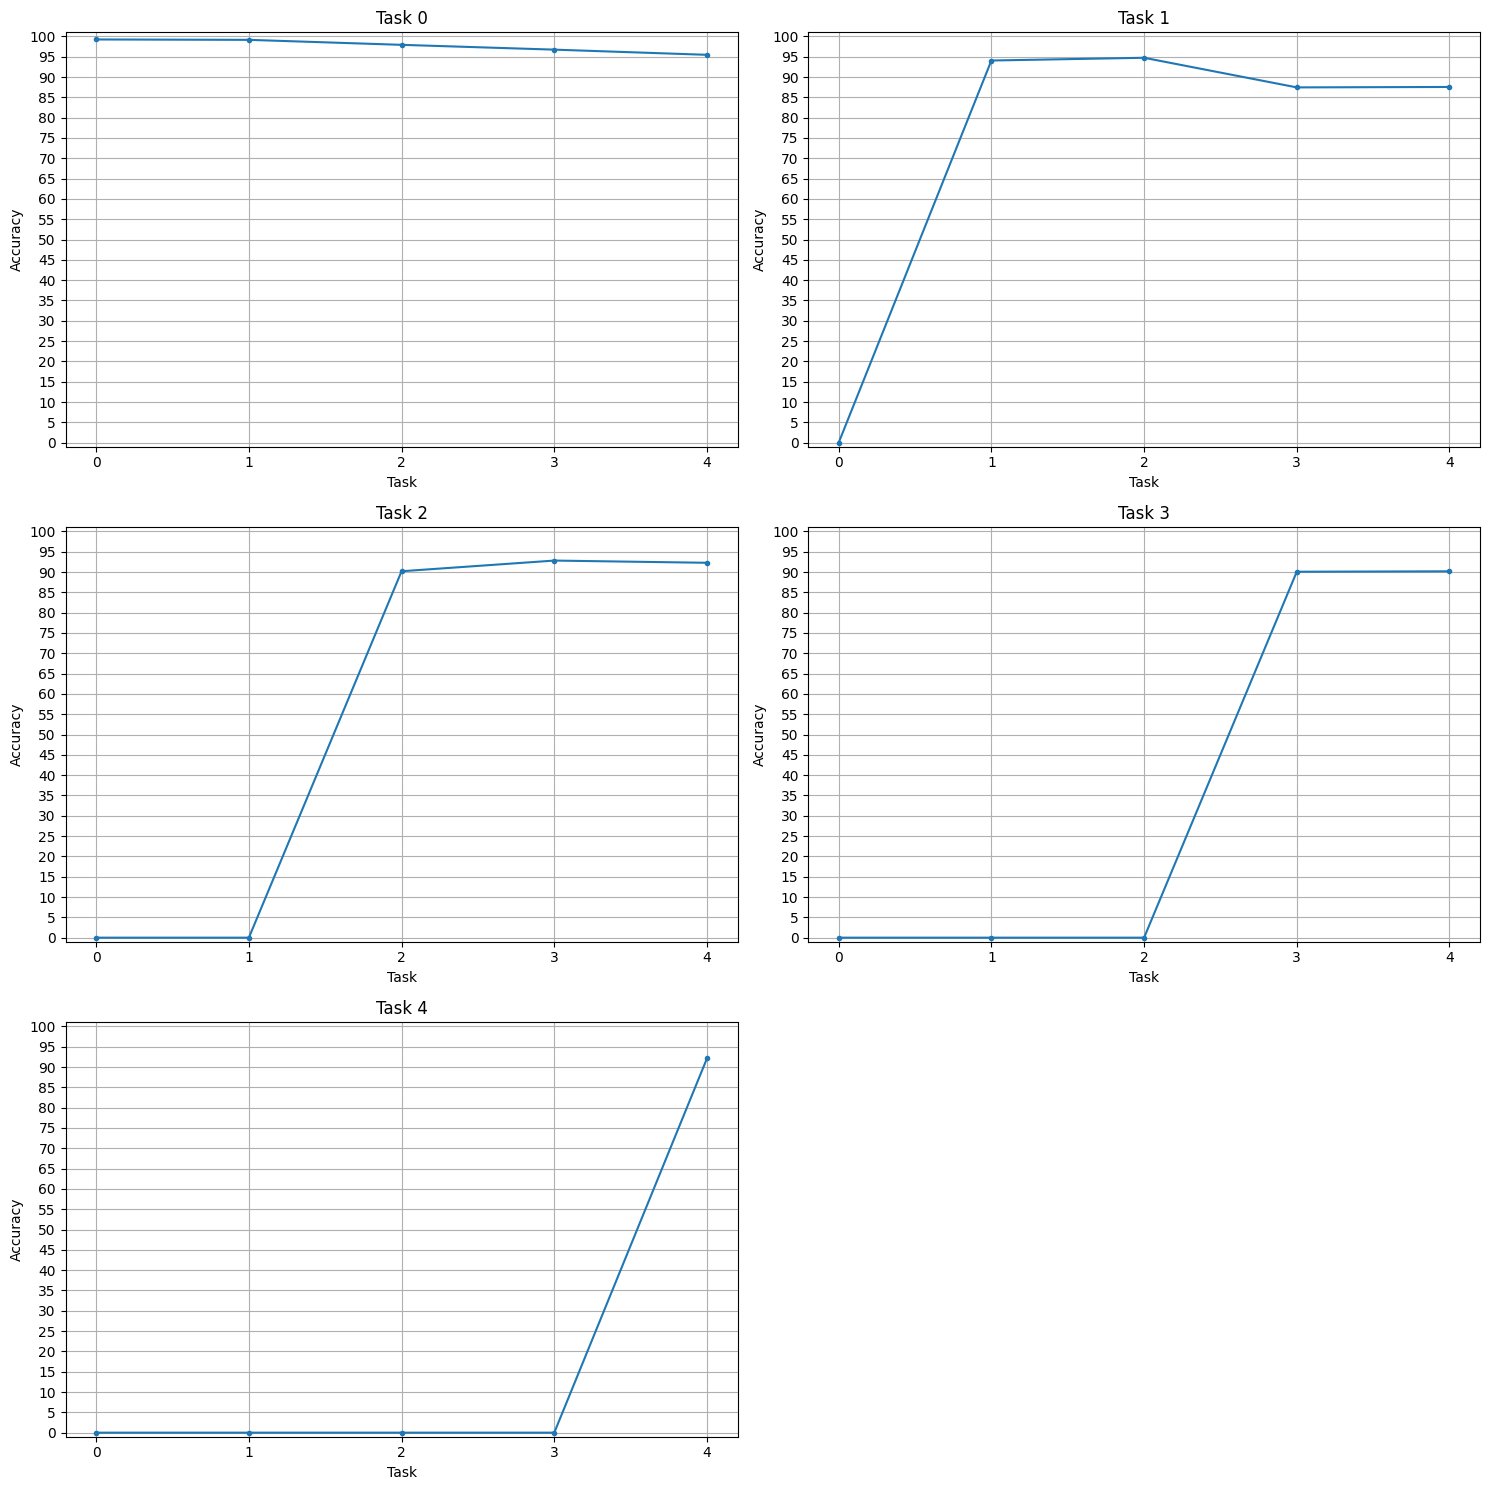

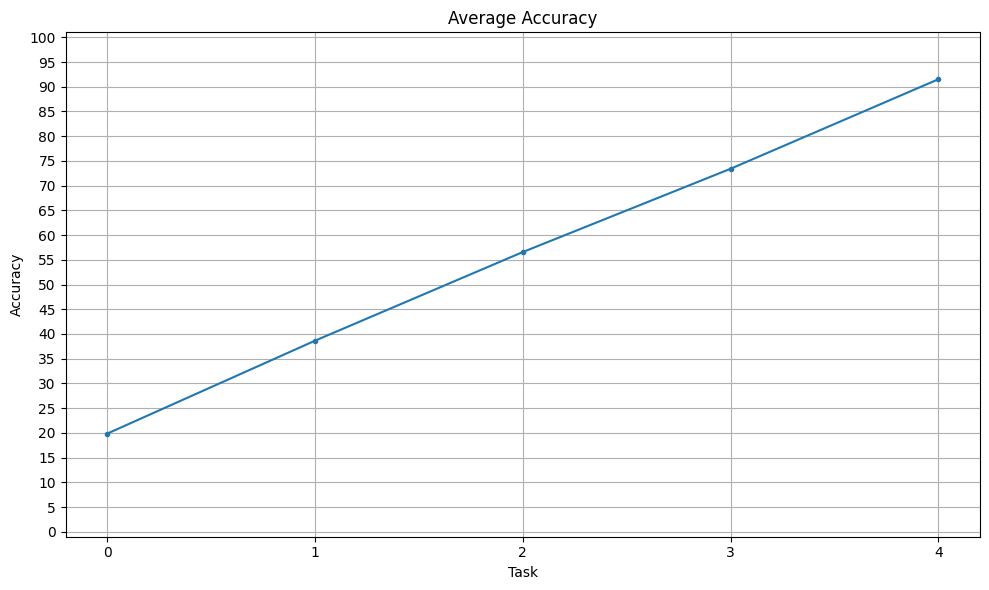

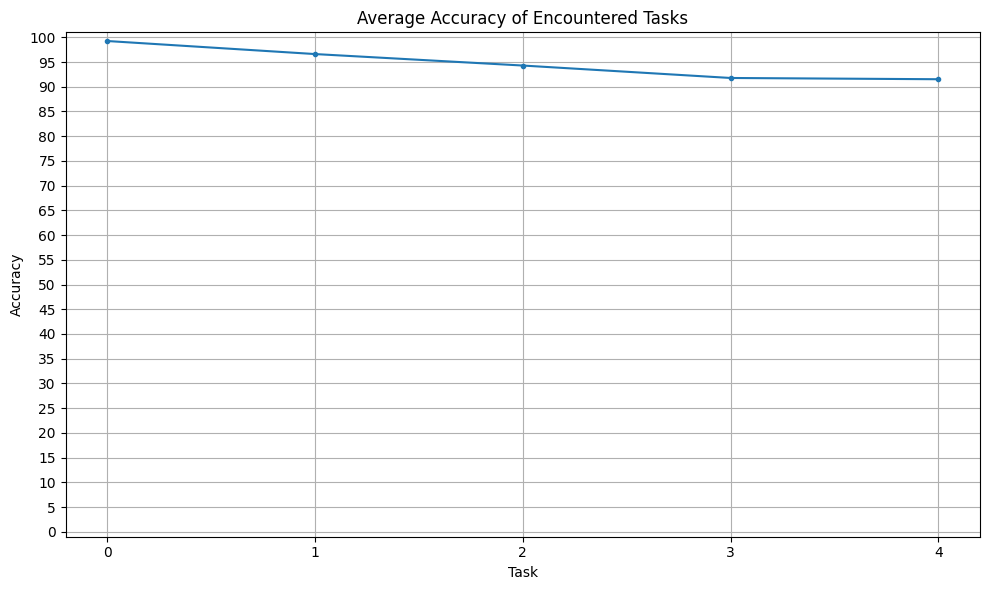

In [4]:
#model4 = PhiNet.from_pretrained("CIFAR-10", 3.0, 0.75, 6.0, 7, 160, classifier=False).to(device)
model4 = PhiNet(input_shape = (1, 28, 28), alpha = 0.5, beta = 1, t_zero = 6,num_layers=7 ,include_top = False, num_classes = 10).to(device)
model4.load_state_dict(torch.load("TestModel/7_Layers/Adam.pth", map_location=torch.device(device)))

model4 = PhiNetV3(model4, latent_layer_num = 9, replace_bn_with_brn = True).to(device)
optimizer4 = Adam(model4.parameters(), lr=0.01, weight_decay=0)

train_epochs = 1

latent_replay = LatentReplay(
    model = model4,
    optimizer = optimizer4,
    criterion = criterion,
    train_mb_size = 21,
    replay_mb_size = 107,
    train_epochs = train_epochs,
    eval_mb_size = eval_mb_size,
    rm_size = 1500,
    manual_mb = True,
    device = device
)

latent_replay.train(train_stream, test_stream, plotting=True)
b,c = latent_replay.test(test_stream)
a = latent_replay.get_tasks_acc()
accs['LatentReplay'] = a

mac = utils.get_MAC(model4, (1,28,28))
print(f"MAC: {mac}")

mean, std = utils.measure_inference_time((1,28,28), model4)
print(f"Average inference time: {mean:.3f} +/- {std:.3f} ms")

In [ ]:
utils.plot_accs(accs)

Strategy: LatentReplay, Tasks: [0, 1, 2, 3, 4]
Task Accuracy: {0: [99.24421350968352, 99.14974019839396, 97.92158715162967, 96.74067076051016, 95.46528105810108], 1: [0.0, 94.0625, 94.73958333333333, 87.44791666666667, 87.55208333333333], 2: [0.0, 0.0, 90.19316493313522, 92.81822684497276, 92.27340267459138], 3: [0.0, 0.0, 0.0, 90.07164790174002, 90.17400204708291], 4: [0.0, 0.0, 0.0, 0.0, 92.1105527638191]}


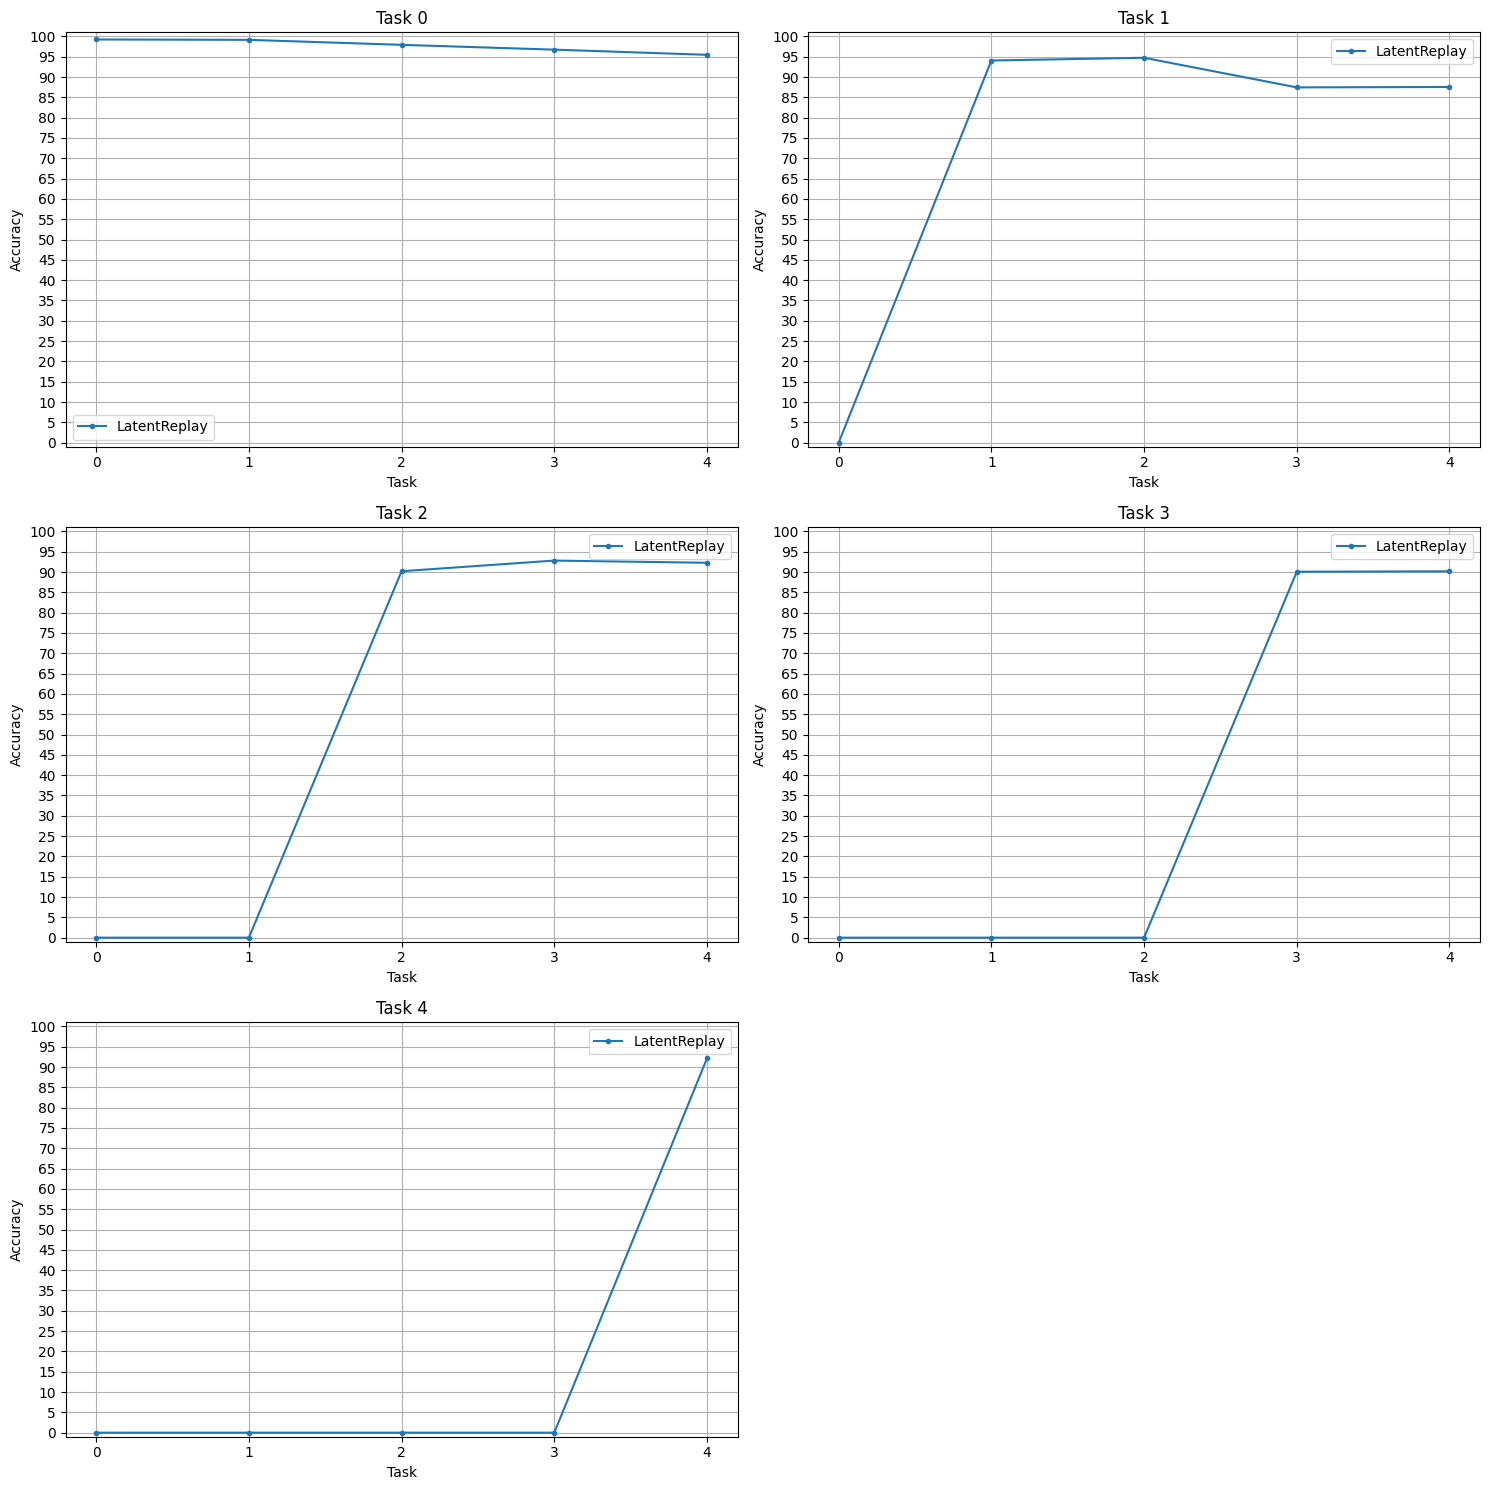

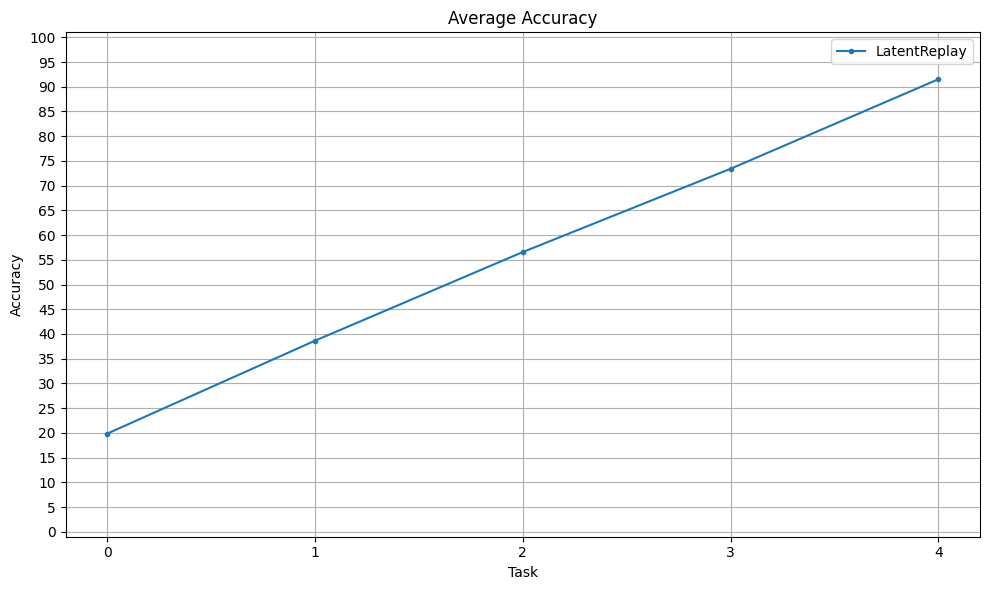

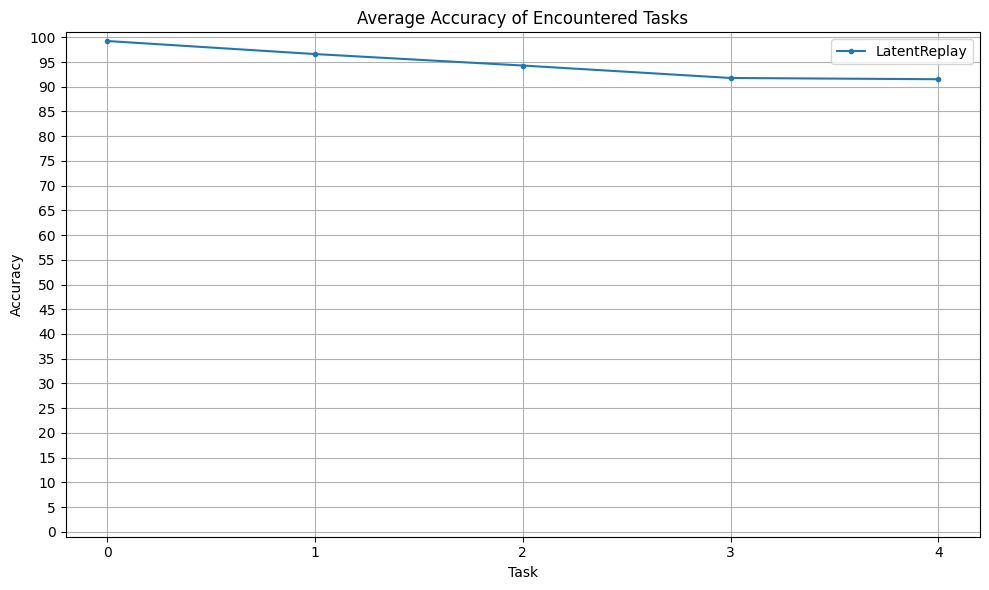

In [5]:
plotter = utils.TaskAccuracyPlotter()

for key, value in accs.items():
    print(f"Strategy: {key}, Tasks: {list(value.keys())}")
    print(f"Task Accuracy: {value}")
    _ = plotter.plot_task_accuracy(value, label=key, plot_task_acc=True, plot_avg_acc=True, plot_encountered_avg=True)

plotter.show_figures()